In [23]:
import torch
from omegaconf import OmegaConf

import bbrl_utils
from bbrl_utils.notebook import setup_tensorboard
from bbrl.stats import WelchTTest
from pmind_utils import (
    DQN,
    DDPG,
    TD3,
    dqn_compute_critic_loss,
    ddqn_compute_critic_loss,
    run_dqn,
    run_ddpg,
    run_td3,
)

bbrl_utils.setup()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Test used algorithms

In [24]:
setup_tensorboard("./outputs/tblogs")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6009 (pid 71584), started 0:02:10 ago. (Use '!kill 71584' to kill it.)

### DQN:

In [25]:
params = {
    "base_dir": "${gym_env.env_name}/dqn-S${algorithm.seed}_${current_time:}",
    # `collect_stats` is True: we keep the cumulated reward for all
    # evaluation episodes
    "collect_stats": True,
    "save_best": False,
    "algorithm": {
        "seed": 4,
        "max_grad_norm": 0.5,
        "epsilon": 0.02,
        "n_envs": 8,
        "n_steps": 32,
        "n_updates": 32,
        "eval_interval": 2000,
        "learning_starts": 5000,
        "nb_evals": 10,
        "buffer_size": 100_000,
        "batch_size": 256,
        "target_critic_update": 1_000,
        "max_epochs": 3_000,
        "discount_factor": 0.99,
        "architecture": {"hidden_size": [256, 256]},
    },
    "gym_env": {
        "env_name": "CartPole-v1",
    },
    "optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
    },
}

dqn = DQN(OmegaConf.create(params))
run_dqn(dqn, dqn_compute_critic_loss)
dqn.visualize_best()

  0%|          | 0/3000 [00:00<?, ?it/s]

Video of best agent recorded in folder outputs/CartPole-v1/dqn-S4_20260207-113838/best_agent


/Users/vlad/miniconda3/envs/bbrl_env/lib/python3.10/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


moviepy is not installed, skipping video display


### DDQN:

In [26]:
params = {
    "base_dir": "${gym_env.env_name}/double-dqn-S${algorithm.seed}_${current_time:}",
    "collect_stats": True,
    "save_best": False,
    "algorithm": {
        "seed": 3,
        "max_grad_norm": 0.5,
        "epsilon": 0.02,
        "n_envs": 8,
        "n_steps": 32,
        "n_updates": 32,
        "eval_interval": 2_000,
        "learning_starts": 5_000,
        "nb_evals": 10,
        "buffer_size": 100_000,
        "batch_size": 256,
        "target_critic_update": 1000,
        "max_epochs": 3_000,
        "discount_factor": 0.99,
        "architecture": {"hidden_size": [128, 128]},
    },
    "gym_env": {
        "env_name": "CartPole-v1",
    },
    "optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
    },
}

ddqn = DQN(OmegaConf.create(params))
run_dqn(ddqn, ddqn_compute_critic_loss)
ddqn.visualize_best()

  0%|          | 0/3000 [00:00<?, ?it/s]

Video of best agent recorded in folder outputs/CartPole-v1/double-dqn-S3_20260207-114225/best_agent
moviepy is not installed, skipping video display


/Users/vlad/miniconda3/envs/bbrl_env/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:586: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
/Users/vlad/Documents/University/Master-MIND/PMIND/ressources/bbrl/src/bbrl/stats.py:29: RuntimeWarning: All-NaN slice encountered
  central = np.nanmedian(sample, axis=1)
/Users/vlad/miniconda3/envs/bbrl_env/lib/python3.10/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,


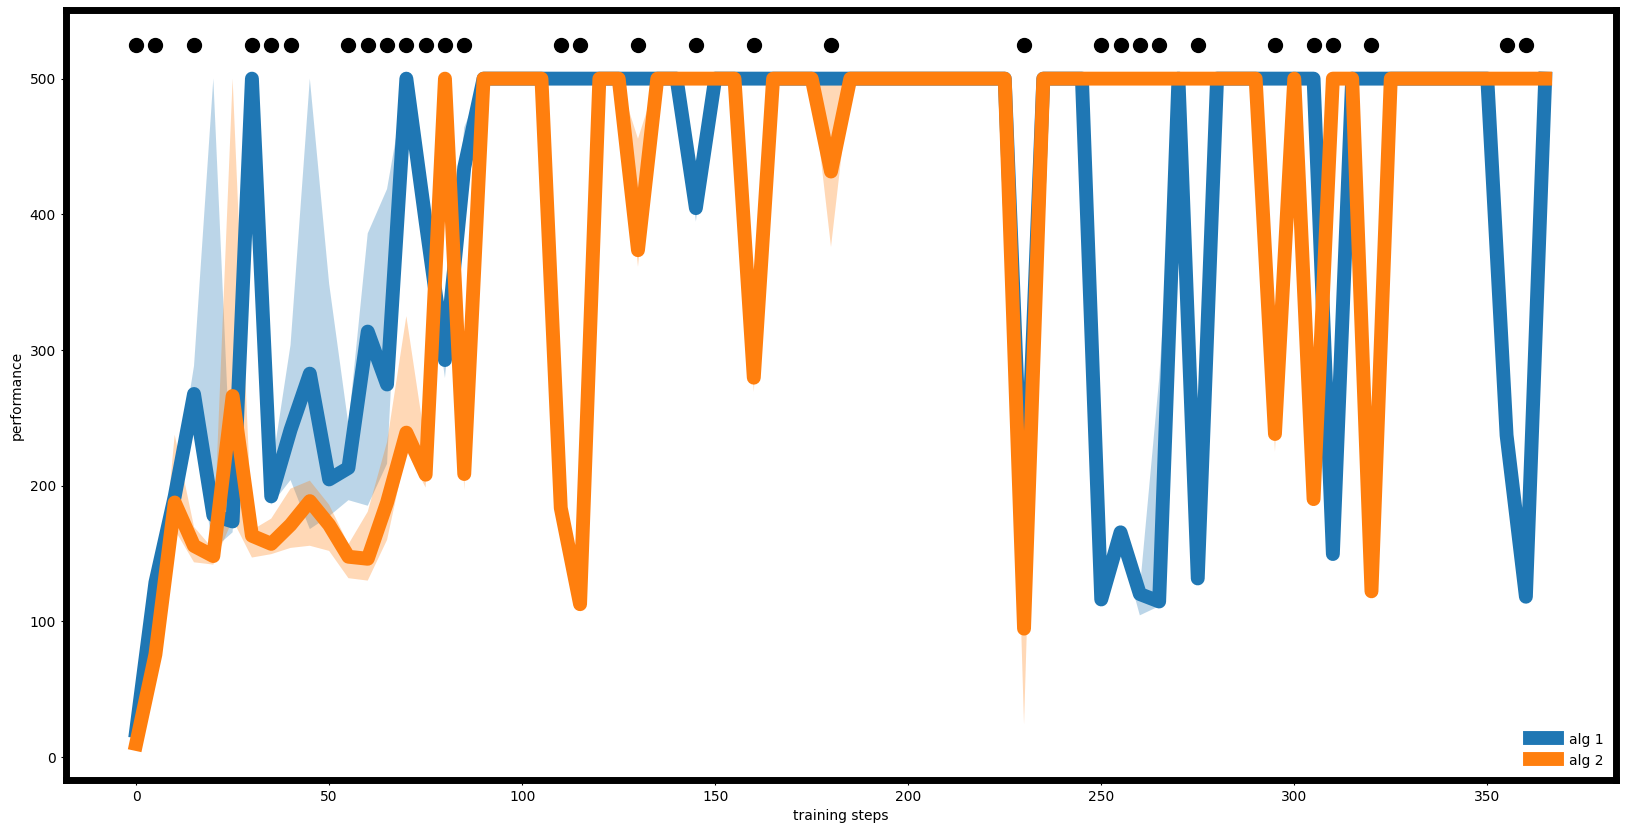

In [27]:
WelchTTest().plot(
    torch.stack(dqn.eval_rewards), torch.stack(ddqn.eval_rewards), save=False
)

### DDPG:

In [28]:
params = {
    "save_best": False,
    "base_dir": "${gym_env.env_name}/ddpg-S${algorithm.seed}_${current_time:}",
    "collect_stats": True,
    # Set to true to have an insight on the learned policy
    # (but slows down the evaluation a lot!)
    "plot_agents": True,
    "algorithm": {
        "seed": 1,
        "max_grad_norm": 0.5,
        "n_envs": 1,
        "n_steps": 100,
        "nb_evals": 10,
        "discount_factor": 0.98,
        "buffer_size": 2e5,
        "batch_size": 64,
        "tau_target": 0.05,
        "eval_interval": 2_000,
        "max_epochs": 11_000,
        # Minimum number of transitions before learning starts
        "learning_starts": 10000,
        "action_noise": 0.1,
        "architecture": {
            "actor_hidden_size": [400, 300],
            "critic_hidden_size": [400, 300],
        },
    },
    "gym_env": {
        "env_name": "CartPoleContinuous-v1",
    },
    "actor_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
    },
    "critic_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
    },
}

ddpg = DDPG(OmegaConf.create(params))
run_ddpg(ddpg)
ddpg.visualize_best()

  0%|          | 0/11000 [00:00<?, ?it/s]

Video of best agent recorded in folder outputs/CartPoleContinuous-v1/ddpg-S1_20260207-114517/best_agent
moviepy is not installed, skipping video display


### TD3:

In [29]:
# Create hyper-params

params = {
    "save_best": False,
    "base_dir": "${gym_env.env_name}/ddpg-S${algorithm.seed}_${current_time:}",
    "collect_stats": True,
    # Set to true to have an insight on the learned policy
    # (but slows down the evaluation a lot!)
    "plot_agents": True,
    "algorithm": {
        "seed": 1,
        "max_grad_norm": 0.5,
        "n_envs": 1,
        "n_steps": 100,
        "nb_evals": 10,
        "discount_factor": 0.98,
        "buffer_size": 2e5,
        "batch_size": 64,
        "tau_target": 0.05,
        "eval_interval": 2_000,
        "max_epochs": 11_000,
        # Minimum number of transitions before learning starts
        "learning_starts": 10000,
        "action_noise": 0.1,

        # TD3 SPECIFIC
        "policy_delay": 2,
        "target_policy_noise": 0.2,
        "target_policy_noise_clip": 0.5,

        "architecture": {
            "actor_hidden_size": [400, 300],
            "critic_hidden_size": [400, 300]
        },
    },
    "gym_env": {
        "env_name": "CartPoleContinuous-v1",
    },
    "actor_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
    },
    "critic_optimizer": {
        "classname": "torch.optim.Adam",
        "lr": 1e-3,
    },
}

td3 = TD3(OmegaConf.create(params))
run_td3(td3)
td3.visualize_best()

  0%|          | 0/11000 [00:00<?, ?it/s]

Video of best agent recorded in folder outputs/CartPoleContinuous-v1/ddpg-S1_20260207-114907/best_agent
moviepy is not installed, skipping video display


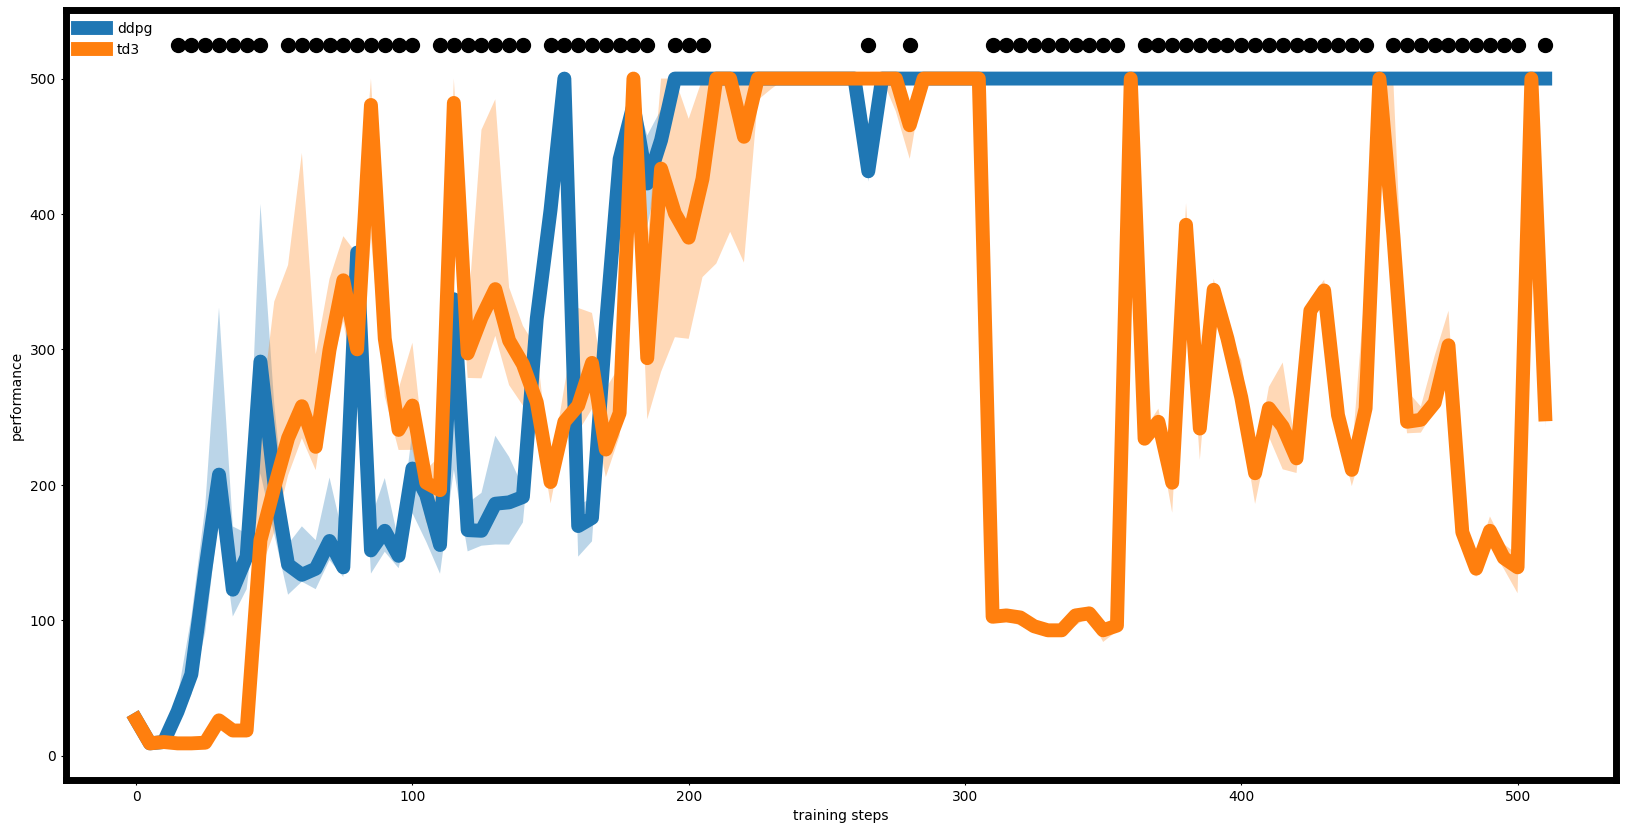

In [30]:
WelchTTest().plot(
    torch.stack(ddpg.eval_rewards),
    torch.stack(td3.eval_rewards),
    legends="ddpg/td3",
    save=False,
)